# Order Profile Analysis
GitHub location: https://github.com/LarsTinnefeld/olist_ecom_analysis.git

**A project of the Olist ecommerce business analysis.**

<img src="https://i2.wp.com/dataneophyte.com/wp-content/uploads/2019/12/Logo-01.png" width="400" height="300">


## Questions to answer
1. What conclusions can we draw from order- and SKU-profile?
2. Impacts of Olist's business model on inventory and fullfillment process
3. Can we predict buying behaviour between articles (association)?

## Table of Contents

I. [Data Import and Wrangling](#data)<br>
II. [Exploratory Date Analysis](#eda)<br>
III. [Order and SKU profile](#profile)<br>
IV. [Affinity Analysis](#affinity)<br>

---
## <a class="anchor" id="data">I. Data Import and Wrangling</a>

### 1. Libraries

In [151]:
import pandas as pd
import numpy as np
from apyori import apriori
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from datetime import datetime as dt
%matplotlib inline
sns.set_style("whitegrid")

### 2. Importing order data
Part of the data was inherited from the initial Olist data analysis.

General data structure:

<img src="https://i.imgur.com/HRhd2Y0.png" width="700" height="450">

We will import the already cleanded dataset from the shared dataset of the Olist business analysis.

<img src="https://github.com/LarsTinnefeld/olist_ecom_analysis/blob/main/Olist-Analysis_1_New_tables.PNG?raw=true" width="700" height="400">

In [152]:
# Importing consolidated order data table
df_orders_consolidated = pd.read_csv('../0 - data/df_orders_consolidated.csv')

In [153]:
# Refresher
df_orders_consolidated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102425 entries, 0 to 102424
Data columns (total 33 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Unnamed: 0                     102425 non-null  int64  
 1   Unnamed: 0.1                   102425 non-null  int64  
 2   order_id                       102425 non-null  object 
 3   customer_id                    102425 non-null  object 
 4   order_status                   102425 non-null  object 
 5   order_purchase_timestamp       102425 non-null  object 
 6   order_approved_at              102425 non-null  object 
 7   order_delivered_carrier_date   102425 non-null  object 
 8   order_delivered_customer_date  102425 non-null  object 
 9   order_estimated_delivery_date  102425 non-null  object 
 10  order_time                     102425 non-null  object 
 11  delivery_time                  102425 non-null  object 
 12  date_ordinal                  

In [154]:
df_orders_consolidated.head()

,Unnamed: 0,Unnamed: 0.1,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,...,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,order_line_cube_in_ltr,price_round,customer_unique_id
0,0,0,2e7a8482f6fb09756ca50c10d7bfc047,08c5351a6aca1c1589a38f244edeee9d,shipped,2016-09-04,2016-10-07,2016-10-18,2016-11-09,2016-10-20,...,59.0,426.0,2.0,1400.0,32.0,6.0,28.0,5.376,40.0,b7d76e111c89f7ebf14761390f0f7d17
1,1,1,35d3a51724a47ef1d0b89911e39cc4ff,27ab53f26192510ff85872aeb3759dcc,delivered,2016-10-04,2016-10-05,2016-10-14,2016-10-26,2016-12-20,...,59.0,426.0,2.0,1400.0,32.0,6.0,28.0,5.376,40.0,f922896769e9517ea3c630f3c8de86d0
2,2,2,c4f710df20f7d1500da1aef81a993f65,4b671f05b6eb9dc1d2c1bae9c8c78536,delivered,2016-10-10,2016-10-10,2016-10-18,2016-10-26,2016-12-14,...,59.0,426.0,2.0,1400.0,32.0,6.0,28.0,5.376,40.0,0ecf7f65b5ff3b9e61b637e59f495e0a
3,3,3,81e5043198a44ddeb226002ff55d8ad4,ddd15ef77c83eea8c534d2896173a927,delivered,2017-01-09,2017-01-09,2017-01-09,2017-02-24,2017-02-24,...,59.0,426.0,2.0,1400.0,32.0,6.0,28.0,10.752,40.0,853ba75a0b423722ccf270eea3b4cfe4
4,4,4,03b218d39c422c250f389120c531b61f,db857a86c685a6a3a02a705961ec1ff1,delivered,2017-01-14,2017-01-14,2017-01-16,2017-01-18,2017-03-01,...,59.0,426.0,2.0,1400.0,32.0,6.0,28.0,5.376,40.0,c83d504c46170342ddbc93c762e0e4ec


In [155]:
def convert_to_dt(dat, cols):
    '''Function takes in a dataframe name and date columns for conversion into datetime format'''
    for col in cols:
        dat[col] = pd.to_datetime(dat[col]).dt.date

In [156]:
# converting dates to datetime
convert_to_dt(df_orders_consolidated, [
    'order_purchase_timestamp',
    'order_approved_at',
    'order_delivered_carrier_date',
    'order_delivered_customer_date'
    ])

In [157]:
df_orders_consolidated.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'order_id', 'customer_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'order_time', 'delivery_time',
       'date_ordinal', 'shipping_time_delta', 'shipping_duration',
       'estimated_duration', 'product_id', 'qty', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value',
       'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'order_line_cube_in_ltr', 'price_round', 'customer_unique_id'],
      dtype='object')

In [158]:
# deleting the "Unnamed" columns
df_orders_consolidated.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1, inplace=True)

### 3. Importing customer data

In [159]:
df_customers = pd.read_csv('../0 - data/olist_customers_dataset.csv')

In [160]:
df_customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [161]:
df_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


Interestingly, there are two customer identifications, where one is a "unique identifier" and the other the "key field" as link to the order tables. That means that the customer_id field is in fact not a unique identifier for the customer. There could be two orders with different customer_ids where in reality these orders stem from the same customer.

In [162]:
df_customers['customer_id'].nunique()

99441

In [163]:
df_customers['customer_unique_id'].nunique()

96096

In [164]:
n_customers = df_customers['customer_unique_id'].nunique()
n_SKUs = df_orders_consolidated['product_id'].nunique()
n_orders = df_orders_consolidated['order_id'].nunique()
print('Unique customers: {}'.format(n_customers))
print('Unique SKUs: {}'.format(n_SKUs))
print('Unique orders: {}'.format(n_orders))

Unique customers: 96096
Unique SKUs: 32951
Unique orders: 98666


We need to invesigate customer behaviour at a later stage. For this, we need to have one unique customer identification. We want to see what products customers buy over time. Therefore we will add the unique customer identification to the order file.

In [165]:
# Creating a customer dictionary as a lookup source
dict_customer = df_customers.set_index('customer_id').to_dict()['customer_unique_id']
len(dict_customer)

99441

In [166]:
# Adding column with unitque user ID to consolidated order table
df_orders_consolidated['customer_unique_id'] = df_orders_consolidated['customer_id'].map(dict_customer)

In [167]:
df_orders_consolidated.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_time,delivery_time,...,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,order_line_cube_in_ltr,price_round,customer_unique_id
0,2e7a8482f6fb09756ca50c10d7bfc047,08c5351a6aca1c1589a38f244edeee9d,shipped,2016-09-04,2016-10-07,2016-10-18,2016-11-09,2016-10-20,21:15:19,13:14:51,...,59.0,426.0,2.0,1400.0,32.0,6.0,28.0,5.376,40.0,b7d76e111c89f7ebf14761390f0f7d17
1,35d3a51724a47ef1d0b89911e39cc4ff,27ab53f26192510ff85872aeb3759dcc,delivered,2016-10-04,2016-10-05,2016-10-14,2016-10-26,2016-12-20,14:23:50,02:44:30,...,59.0,426.0,2.0,1400.0,32.0,6.0,28.0,5.376,40.0,f922896769e9517ea3c630f3c8de86d0
2,c4f710df20f7d1500da1aef81a993f65,4b671f05b6eb9dc1d2c1bae9c8c78536,delivered,2016-10-10,2016-10-10,2016-10-18,2016-10-26,2016-12-14,15:50:01,15:53:51,...,59.0,426.0,2.0,1400.0,32.0,6.0,28.0,5.376,40.0,0ecf7f65b5ff3b9e61b637e59f495e0a
3,81e5043198a44ddeb226002ff55d8ad4,ddd15ef77c83eea8c534d2896173a927,delivered,2017-01-09,2017-01-09,2017-01-09,2017-02-24,2017-02-24,00:37:18,09:10:53,...,59.0,426.0,2.0,1400.0,32.0,6.0,28.0,10.752,40.0,853ba75a0b423722ccf270eea3b4cfe4
4,03b218d39c422c250f389120c531b61f,db857a86c685a6a3a02a705961ec1ff1,delivered,2017-01-14,2017-01-14,2017-01-16,2017-01-18,2017-03-01,14:20:01,09:23:45,...,59.0,426.0,2.0,1400.0,32.0,6.0,28.0,5.376,40.0,c83d504c46170342ddbc93c762e0e4ec


In [168]:
# Check
df_orders_consolidated['customer_unique_id'].nunique()

95420

This seemed to have worked and proves that some customers have placed more than one order line.

### 4. Importing product data

In [169]:
df_products = pd.read_csv('../0 - data/olist_products_dataset.csv')

In [170]:
df_products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [171]:
df_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


There are some missing data. These gaps were already filled in and merged in the orders_consolidated table.

Reason for importing: I want to know the number of available SKUs (products), rather than the number of SKUs which were active.

In [172]:
# Number of SKUs
df_products['product_id'].nunique()

32951

In [173]:
# Importing the translation lookup table
df_translations = pd.read_csv('../0 - data/product_category_name_translation.csv')

In [174]:
df_translations.head()

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


In [175]:
df_translations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   product_category_name          71 non-null     object
 1   product_category_name_english  71 non-null     object
dtypes: object(2)
memory usage: 1.2+ KB


In [176]:
# adding the english procuct category name to the products list
df_products = df_products.merge(df_translations, on='product_category_name', how='left')
df_products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0,perfumery
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0,art
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0,sports_leisure
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0,baby
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0,housewares


In [177]:
df_products.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32951 entries, 0 to 32950
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   product_id                     32951 non-null  object 
 1   product_category_name          32341 non-null  object 
 2   product_name_lenght            32341 non-null  float64
 3   product_description_lenght     32341 non-null  float64
 4   product_photos_qty             32341 non-null  float64
 5   product_weight_g               32949 non-null  float64
 6   product_length_cm              32949 non-null  float64
 7   product_height_cm              32949 non-null  float64
 8   product_width_cm               32949 non-null  float64
 9   product_category_name_english  32328 non-null  object 
dtypes: float64(7), object(3)
memory usage: 2.8+ MB


There are a few category names missing. Let's see if we have these names in the order file.

In [178]:
# Show all categories without translations
(
    df_products[(df_products['product_category_name_english']
    .isna()) & (~df_products['product_category_name'].isna())]
)

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
1628,0105b5323d24fc655f73052694dbbb3a,pc_gamer,59.0,621.0,4.0,2839.0,19.0,16.0,18.0,NaN
5821,6fd83eb3e0799b775e4f946bd66657c0,portateis_cozinha_e_preparadores_de_alimentos,52.0,280.0,1.0,1200.0,25.0,33.0,25.0,NaN
7325,5d923ead886c44b86845f69e50520c3e,portateis_cozinha_e_preparadores_de_alimentos,58.0,284.0,1.0,1200.0,25.0,33.0,25.0,NaN
7478,6727051471a0fc4a0e7737b57bff2549,pc_gamer,60.0,1532.0,3.0,650.0,16.0,22.0,20.0,NaN
8819,bed164d9d628cf0593003389c535c6e0,portateis_cozinha_e_preparadores_de_alimentos,54.0,382.0,2.0,850.0,30.0,21.0,22.0,NaN
11039,1220978a08a6b29a202bc015b18250e9,portateis_cozinha_e_preparadores_de_alimentos,46.0,280.0,1.0,1200.0,25.0,33.0,25.0,NaN
14266,ae62bb0f95af63d64eae5f93dddea8d3,portateis_cozinha_e_preparadores_de_alimentos,59.0,927.0,1.0,10600.0,40.0,20.0,38.0,NaN
16182,1954739d84629e7323a4295812a3e0ec,portateis_cozinha_e_preparadores_de_alimentos,58.0,792.0,4.0,750.0,30.0,30.0,30.0,NaN
16930,dbe520fb381ad695a7e1f2807d20c765,pc_gamer,60.0,840.0,6.0,800.0,18.0,22.0,22.0,NaN
17800,c7a3f1a7f9eef146cc499368b578b884,portateis_cozinha_e_preparadores_de_alimentos,52.0,1372.0,5.0,7350.0,40.0,30.0,23.0,NaN


In [179]:
# Adding manually translations
df_products['product_category_name_english'] = np.where(df_products[
    'product_category_name']=='pc_gamer',
    'pc_games',
    df_products['product_category_name_english'
    ])
df_products['product_category_name_english'] = np.where(df_products[
    'product_category_name']=='portateis_cozinha_e_preparadores_de_alimentos',
    'portable_cooking_ware',
    df_products['product_category_name_english'
    ])

In [180]:
# Check
(
    df_products[(df_products['product_category_name_english']
    .isna()) & (~df_products['product_category_name'].isna())]
)

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english


In [181]:
# Double-check
df_products.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32951 entries, 0 to 32950
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   product_id                     32951 non-null  object 
 1   product_category_name          32341 non-null  object 
 2   product_name_lenght            32341 non-null  float64
 3   product_description_lenght     32341 non-null  float64
 4   product_photos_qty             32341 non-null  float64
 5   product_weight_g               32949 non-null  float64
 6   product_length_cm              32949 non-null  float64
 7   product_height_cm              32949 non-null  float64
 8   product_width_cm               32949 non-null  float64
 9   product_category_name_english  32341 non-null  object 
dtypes: float64(7), object(3)
memory usage: 2.8+ MB


More is not possible. Adding english categoy name to df_orders_consolidated

In [182]:
dict_tranlate = df_products.set_index('product_category_name')\
    .to_dict()['product_category_name_english']

In [183]:
df_orders_consolidated['product_category_name_english']\
    = df_orders_consolidated['product_category_name'].map(dict_tranlate)
df_orders_consolidated[['product_category_name', 'product_category_name_english']]

,product_category_name,product_category_name_english
0,moveis_decoracao,furniture_decor
1,moveis_decoracao,furniture_decor
2,moveis_decoracao,furniture_decor
3,moveis_decoracao,furniture_decor
4,moveis_decoracao,furniture_decor
...,...,...
102420,beleza_saude,health_beauty
102421,moveis_decoracao,furniture_decor
102422,relogios_presentes,watches_gifts
102423,artigos_de_festas,party_supplies


---
## <a class="anchor" id="eda">II. Exploratory Data Analysis</a>
The focus is on getting an understanding around order composition and products.

### 1. Which customers ordered the most products?

Text(0, 0.5, 'Count of order lines')

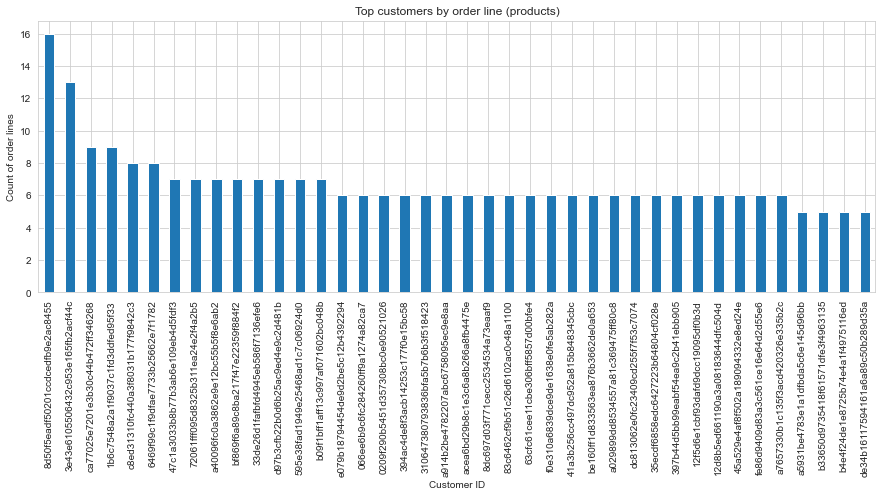

In [184]:
df_orders_consolidated.groupby('customer_unique_id')\
    .agg({'customer_id': 'count'})\
    .sort_values('customer_id', ascending=False).head(40).plot(
        kind='bar',
        figsize=(15,5),
        legend=False);
plt.title('Top customers by order line (products)')
plt.xlabel('Customer ID')
plt.ylabel('Count of order lines')

16 records means 16 order lines, not necessarily 16 orders. Let's check how many orders have the top customers placed:

### 2. Which customers placed the most orders?

Text(0, 0.5, 'Count of orders')

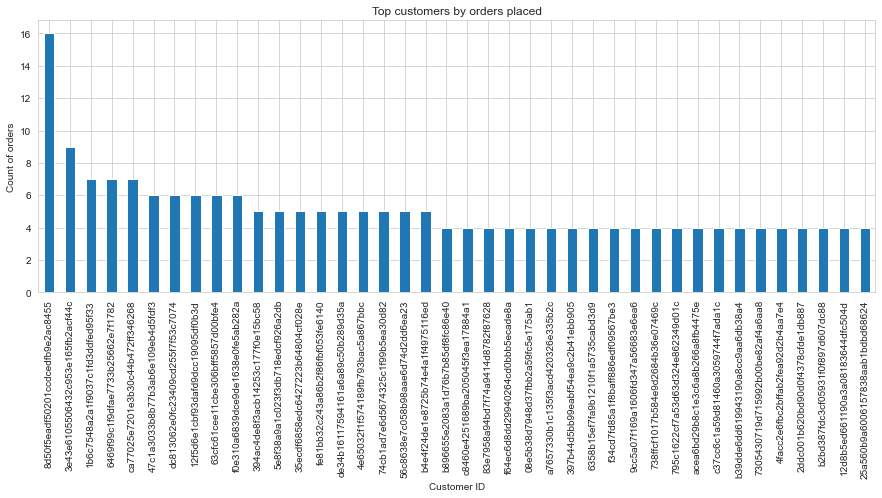

In [185]:
df_orders_consolidated\
    .groupby(['customer_unique_id', 'order_id'], as_index=False)\
    .agg({'customer_id': 'count'})\
    .groupby('customer_unique_id')\
    .agg({'order_id': 'count'})\
    .sort_values('order_id', ascending=False)\
    .head(40).plot(kind='bar', figsize=(15,5), legend=False);
plt.title('Top customers by orders placed')
plt.xlabel('Customer ID')
plt.ylabel('Count of orders')

That means that the top customer place 16 orders with each only one product but all customers after that have often more than one product in the order. The number of order lines (SKUs)in a typical ecommerce order will be very small, but I will try to see if there are some correlations between products in the same order (affinity analysis) further down.

### 3. What is the order composition in view of product category?

In [186]:
# As a refresher: Number of unique categories
df_orders_consolidated['product_category_name_english'].nunique()

73

In [187]:
# Creating a category- order grouped dataframe
df_order_class_comp = df_orders_consolidated.groupby([
    'order_id',
    'product_category_name_english'
    ], as_index=False).agg({
        'product_id': 'count',
        'qty': 'sum',
        'price': 'sum',
        'order_line_cube_in_ltr': 'sum',
        'product_weight_g': 'sum',
        'estimated_duration': 'first',
        'shipping_duration': 'first',
        'shipping_time_delta': 'first',
        'order_purchase_timestamp': 'first'
        })

In [188]:
df_order_class_comp.rename(columns={
    'qty': 'total_qty',
    'price': 'total_price',
    'order_line_cube_in_ltr': 'total_cube',
    'product_weight_g': 'total_weight'
    }, inplace=True)

In [189]:
df_order_class_comp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98019 entries, 0 to 98018
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_id                       98019 non-null  object 
 1   product_category_name_english  98019 non-null  object 
 2   product_id                     98019 non-null  int64  
 3   total_qty                      98019 non-null  int64  
 4   total_price                    98019 non-null  float64
 5   total_cube                     98019 non-null  float64
 6   total_weight                   98019 non-null  float64
 7   estimated_duration             98019 non-null  int64  
 8   shipping_duration              98019 non-null  int64  
 9   shipping_time_delta            98019 non-null  int64  
 10  order_purchase_timestamp       98019 non-null  object 
dtypes: float64(3), int64(5), object(3)
memory usage: 9.0+ MB


In [190]:
df_order_class_comp.head()

,order_id,product_category_name_english,product_id,total_qty,total_price,total_cube,total_weight,estimated_duration,shipping_duration,shipping_time_delta,order_purchase_timestamp
0,00010242fe8c5a6d1ba2dd792cb16214,cool_stuff,1,1,58.90,3.528,650.0,16,7,9,2017-09-13
1,00018f77f2f0320c557190d7a144bdd3,pet_shop,1,1,239.90,60.000,30000.0,19,16,3,2017-04-26
2,000229ec398224ef6ca0657da4fc703e,furniture_decor,1,1,199.00,14.157,3050.0,22,8,14,2018-01-14
3,00024acbcdf0a6daa1e931b038114c75,perfumery,1,1,12.99,2.400,200.0,12,6,6,2018-08-08
4,00042b26cf59d7ce69dfabb4e55b4fd9,garden_tools,1,1,199.90,42.000,3750.0,41,25,16,2017-02-04


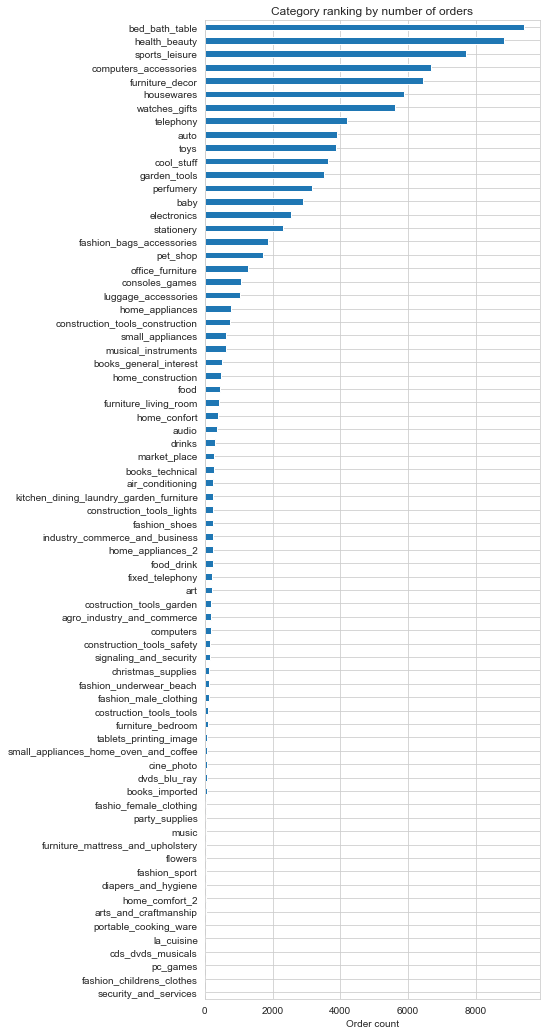

In [191]:
df_order_class_comp.groupby('product_category_name_english')\
    .agg({'order_id': 'count'})\
    .sort_values('order_id')\
    .plot(kind='barh', figsize=(6,18), legend=False);
plt.title('Category ranking by number of orders')
plt.ylabel('');
plt.xlabel('Order count');

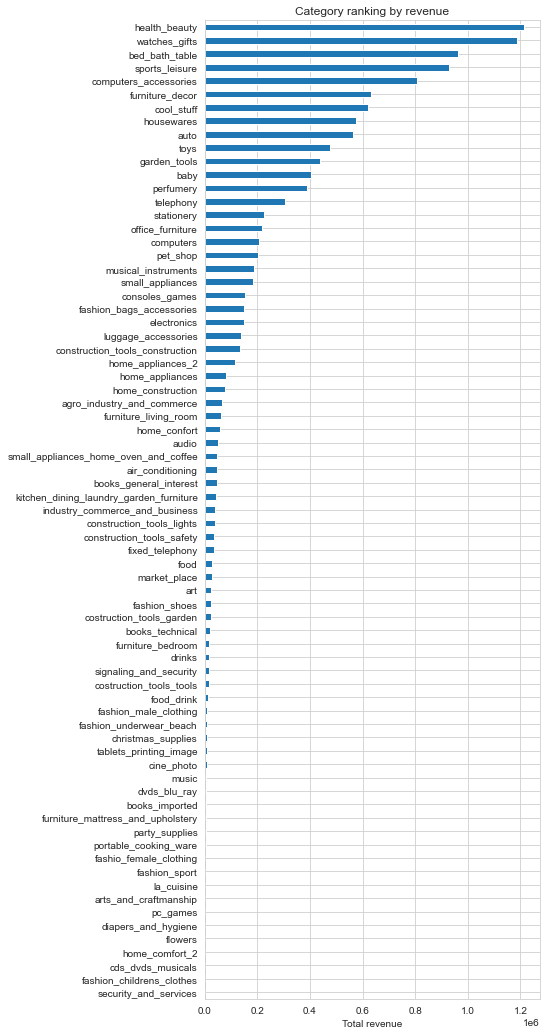

In [192]:
# Product category ranking by revenue
df_order_class_comp.groupby('product_category_name_english')\
    .agg({'total_price': 'sum'})\
    .sort_values('total_price')\
    .plot(kind='barh', figsize=(6,18), legend=False);
plt.title('Category ranking by revenue')
plt.ylabel('');
plt.xlabel('Total revenue');

The number of products of the top 5 products would be interesting, also for the warehousing process.

In [193]:
(
df_orders_consolidated
.groupby(['product_category_name_english', 'product_id'], as_index=False)
.agg({'price': 'sum'})
.groupby('product_category_name_english')
.agg({'product_id':'count', 'price': 'sum'})
.sort_values('price', ascending=False)
.head(5)
.round(0)
.rename(columns={'product_id': 'SKUs'})
)

,SKUs,price
product_category_name_english,,
health_beauty,2444,1212150.0
watches_gifts,1329,1187534.0
bed_bath_table,3029,963520.0
sports_leisure,2867,929271.0
computers_accessories,1639,806515.0


This table was also generated in the previous part of the project (Business Trend Analysis):

<img src="https://github.com/LarsTinnefeld/olist_ecom_analysis/blob/main/Olist_top_categories.PNG?raw=true" width="700" height="212">

High tunover, small item size, low SKU count can be translated into a good pick density and effective pick.

The top fife caregories alone already create more than 40% of the turnover.

This information will be considered in the concept phase.

### 4. Category correlation (similarity)
Which cetegories are similar based on orders?

In [194]:
# Creating a function that returns a sparse matrix
def create_category_order_matrix(df, row, col, elm):
    '''
    Description:
    Return a matrix with order IDs as rows and category names on the columns with count of values where an order contained the product category

    INPUT:
    df - pandas dataframe
    row - field name to be used for the rows
    col - field name to be used for the columns
    elm - field name to be used as matrix elements (counte values)
    
    OUTPUT:
    mat_cat_order - category-order matrix 
    
    '''
    mat_cat_order = df.groupby([
        row,
        col
    ]).agg({elm: 'count'}).unstack().fillna(0)
    
    return mat_cat_order # return the user_item matrix

In [195]:
# Sparse matrix for categoy - orders
mat_cat_order = create_category_order_matrix(df_order_class_comp, 'product_category_name_english', 'order_id', 'total_qty')

In [196]:
mat_cat_order.head()

total_qty  \
order_id                      00010242fe8c5a6d1ba2dd792cb16214   
product_category_name_english                                    
agro_industry_and_commerce                                 0.0   
air_conditioning                                           0.0   
art                                                        0.0   
arts_and_craftmanship                                      0.0   
audio                                                      0.0   

                                                                \
order_id                      00018f77f2f0320c557190d7a144bdd3   
product_category_name_english                                    
agro_industry_and_commerce                                 0.0   
air_conditioning                                           0.0   
art                                                        0.0   
arts_and_craftmanship                                      0.0   
audio                                                      0.0   

                                                                \
order_id                      000229ec398224ef6ca0657da4fc703e   
product_category_name_english                                    
agro_industry_and_commerce                                 0.0   
air_conditioning                                           0.0   
art                                                        0.0   
arts_and_craftmanship                                      0.0   
audio                                                      0.0   

                                                                \
order_id                      00024acbcdf0a6daa1e931b038114c75   
product_category_name_english                                    
agro_industry_and_commerce                                 0.0   
air_conditioning                                           0.0   
art                                                        0.0   
arts_and_craftmanship                                      0.0   
audio                                                      0.0   

                                                                \
order_id                      00042b26cf59d7ce69dfabb4e55b4fd9   
product_category_name_english                                    
agro_industry_and_commerce                                 0.0   
air_conditioning                                           0.0   
art                                                        0.0   
arts_and_craftmanship                                      0.0   
audio                                                      0.0   

                                                                \
order_id                      00048cc3ae777c65dbb7d2a0634bc1ea   
product_category_name_english                                    
agro_industry_and_commerce                                 0.0   
air_conditioning                                           0.0   
art                                                        0.0   
arts_and_craftmanship                                      0.0   
audio                                                      0.0   

                                                                \
order_id                      00054e8431b9d7675808bcb819fb4a32   
product_category_name_english                                    
agro_industry_and_commerce                                 0.0   
air_conditioning                                           0.0   
art                                                        0.0   
arts_and_craftmanship                                      0.0   
audio                                                      0.0   

                                                                \
order_id                      000576fe39319847cbb9d288c5617fa6   
product_category_name_english                                    
agro_industry_and_commerce                                 0.0   
air_conditioning                                           0.0   
art                 

In [197]:
# Any order contained two articles of the same category?
len(np.where(mat_cat_order > 1))

2

Only two orders had two products of the same category.

Let's do some experimenting and develop an algorithm which returns similar categories based on the order history (Collaborative Filtering based on dot-product). I will use the new sparse matrix to do this.

In [198]:
def find_similar_categories(product_category_name, mat_cat_order=mat_cat_order):
    '''
    A function that calculates the similarity of every pair of category based on the dot product

    INPUT:
    product_category_name - (str) a product category name
    mat_cat_order - (Numpy matrix) matrix of product category by order ID: 
                The matrix elements are counts of instances.
    
    Output:
    similar_categories - Ordered list where the closest category are listed first
    '''
    # Calculate similarity and sort
    lst_orders = mat_cat_order.loc[product_category_name]
    arr_category = (mat_cat_order.index.tolist())
    unique_categories = len(mat_cat_order)
    
    dist_to_cat = []
    for cat in range(unique_categories):
        dist_to_cat.append(np.dot(lst_orders, mat_cat_order.iloc[cat]))
        
    df_dists = pd.DataFrame({
        'category': arr_category,
        'dist_to_cat': dist_to_cat
    }).sort_values('dist_to_cat', ascending=False)[1:]

    # create list of just the ids
    similar_categories = df_dists['category'].tolist()
   
    # remove the own user's id
    
    return similar_categories # return a list of the categories in order from most to least similar

In [199]:
# Let's check some categories
print('5 most similar categories to "sports_leisure": {}'.format(find_similar_categories('sports_leisure')[:5]))
print('5 most similar categories to "music": {}'.format(find_similar_categories('music')[:5]))
print('5 most similar categories to "watches_gifts": {}'.format(find_similar_categories('watches_gifts')[:5]))

5 most similar categories to "sports_leisure": ['health_beauty', 'housewares', 'watches_gifts', 'toys', 'auto']
5 most similar categories to "music": ['perfumery', 'books_technical', 'furniture_living_room', 'home_construction', 'luggage_accessories']
5 most similar categories to "watches_gifts": ['furniture_decor', 'audio', 'sports_leisure', 'health_beauty', 'cool_stuff']


This is a nice algorithm which I later can also use as a recommendation application.

---
### 5. Conclusion and summary of EDA

The focus was on getting an understanding around order composition and products.

- Orders are typically very small and mostly containing one products
- There are 73 product categories, of which the top 5 create 40% of the turnover


In [200]:
n_sample_timespan = df_orders_consolidated['order_purchase_timestamp'].max()\
    - df_orders_consolidated['order_purchase_timestamp'].min()
print('Important key figures')
print('Number of active SKUs: {}'.format(n_SKUs))
print('Number of orders: {}'.format(n_orders))
print('Number of customers: {}'.format(n_customers))
print('Number of categories: {}'.format(len(mat_cat_order)))
print('Active days: {}'.format(df_orders_consolidated['order_purchase_timestamp'].nunique()))
print('Total time span: {}'.format(n_sample_timespan))

Important key figures
Number of active SKUs: 32951
Number of orders: 98666
Number of customers: 96096
Number of categories: 73
Active days: 616
Total time span: 729 days, 0:00:00


---
## <a class="anchor" id="profile">III. Order and SKU profile</a>
Question to answer:

** What conclusions can we draw from the order- and SKU-profile? **

** Impacts of Olist business model on inventory and fullfillment process **

### 1. Order profile (units per line, units per order, lines per order)

In [201]:
df_upo_lpo = df_orders_consolidated\
    .groupby('order_id')\
    .agg({
        'qty': 'sum',
        'product_id': 'count'
        })\
    .reset_index()
df_upo_lpo.rename(columns = {
    'qty': 'units',
    'product_id': 'lines'
    }, inplace = True)

In [202]:
df_upo_lpo

,order_id,units,lines
0,00010242fe8c5a6d1ba2dd792cb16214,1,1
1,00018f77f2f0320c557190d7a144bdd3,1,1
2,000229ec398224ef6ca0657da4fc703e,1,1
3,00024acbcdf0a6daa1e931b038114c75,1,1
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,1
...,...,...,...
98661,fffc94f6ce00a00581880bf54a75a037,1,1
98662,fffcd46ef2263f404302a634eb57f7eb,1,1
98663,fffce4705a9662cd70adb13d4a31832d,1,1
98664,fffe18544ffabc95dfada21779c9644f,1,1


Plotting order profile charts

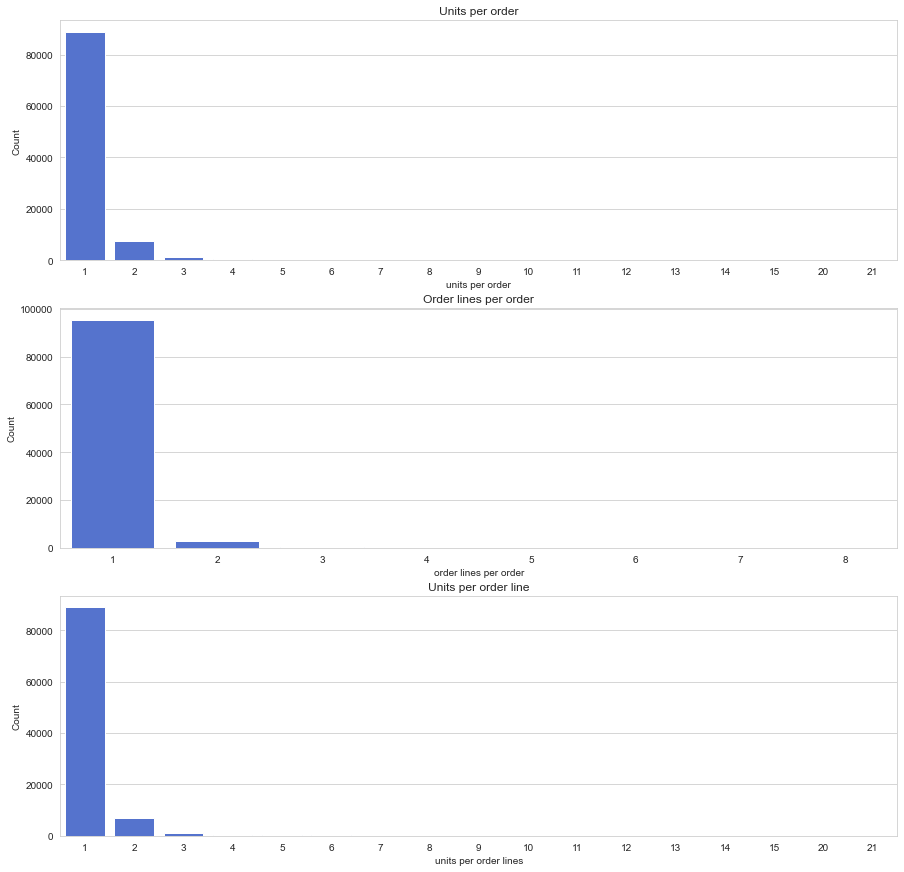

In [203]:
fig, ax = plt.subplots(3, 1, figsize = (15, 15))
sns.countplot(df_upo_lpo['units'], ax = ax[0], color='royalblue')
sns.countplot(df_upo_lpo['lines'], ax = ax[1], color='royalblue')
sns.countplot(df_order_class_comp['total_qty'], ax = ax[2], color='royalblue')
ax[0].set(
    title = 'Units per order',
    xlabel = 'units per order',
    ylabel = 'Count'
    )
ax[1].set(
    title = 'Order lines per order',
    xlabel = 'order lines per order',
    ylabel = 'Count'
    )
ax[2].set(
    title = 'Units per order line',
    xlabel = 'units per order lines',
    ylabel = 'Count'
    );

A very inportant metric in logistics, especially in ecommerce warehousing, is the portion SIO (single-item orders) and MIO (multi-item orders).

Also important is SLO (single-line orders) and MLO (multi-line orders), which indicates the proportion of the orders which only contained one SKU vs. multiple.

What are SIO, MIO, SLO and MLO?

In [204]:
sio = df_upo_lpo[df_upo_lpo['units']==1]['units'].sum()/df_upo_lpo['units'].sum()
mio = 1 - sio
slo = df_upo_lpo[df_upo_lpo['lines']==1]['lines'].sum()/df_upo_lpo['lines'].sum()
mlo = 1 - slo
print('SIO: {}'.format(sio))
print('MIO: {}'.format(mio))
print('SLO: {}'.format(slo))
print('MLO: {}'.format(mlo))

SIO: 0.7888415446071904
MIO: 0.21115845539280964
SLO: 0.9317061264339761
MLO: 0.0682938735660239


This looks typical e-commerce: mostly SIO (single item orders); two-step-order picking is an option to deal with this (batch pick, sort, pack)

### 2. Generating pareto diagrams
We will base them on different metrics:
- units
- lines
- volume (cube)

Step 1: Creating a SKU list with aggregated values

In [205]:
df_SKUs = df_orders_consolidated\
    .groupby('product_id')\
    .agg({
        'qty': 'sum',
        'order_id': 'count',
        'order_line_cube_in_ltr': 'sum',
        'price': 'sum',
        'shipping_duration': 'mean'})

In [206]:
df_SKUs.rename(columns = {
        'qty': 'total_qty',
        'order_id': 'total_lines',
        'order_line_cube_in_ltr': 'total_cube',
        'shipping_duration': 'avg_ship_duration',
        'price': 'total_price'
        }, inplace = True)

In [207]:
# Adding counting column
df_SKUs['counter'] = 1

Need to sort by quantity, then add a cummulating percent counter for unit based pareto.

In [208]:
def classifier(num):
    '''
    Function to assign the velocity class to SKUs

    Input:
    - num - cumulative percentage value

    Output:
    - v_class - velocity class
    '''
    if num < 5:
        v_class = 'A'
    elif num < 20:
        v_class = 'B'
    elif num < 50:
        v_class = 'C'
    else:
        v_class = 'D'
    return v_class

In [209]:
def pareto_izer(dat, col):
    '''A function which adds prepares and executes a pareto curve for a given feature
    The dataframe is sorted in descending order for the given feature
    
    Inputs:     data frame, feature (column)
    
    Outputs:    column with cumulated, sorted veature values
                Pareto chart'''
    
    dat.sort_values(by = col, ascending = False, inplace = True) # sort by the feature   
    dat['cum_' + col] = dat[col].cumsum()/dat[col].sum()*100 # add or re-assign column whith the cummulated sum
    df_SKUs['v_class_' + col] = dat['cum_' + col].map(classifier) # add or re-assign SKU velocity class (ABC)

    # Plotting the chart
    f, ax = plt.subplots(figsize = (15, 7))
    ax = sns.lineplot(x = dat['counter']\
        .cumsum()/dat['counter']\
        .sum()*100, data = dat, y = ('cum_' + col))
    ax = plt.title('Pareto chart of % {} over % SKUs'. format(col))
    ax = plt.xlabel('Percentage SKUs')
    ax = plt.ylabel('Percentage {}'.format(col))
    return ax

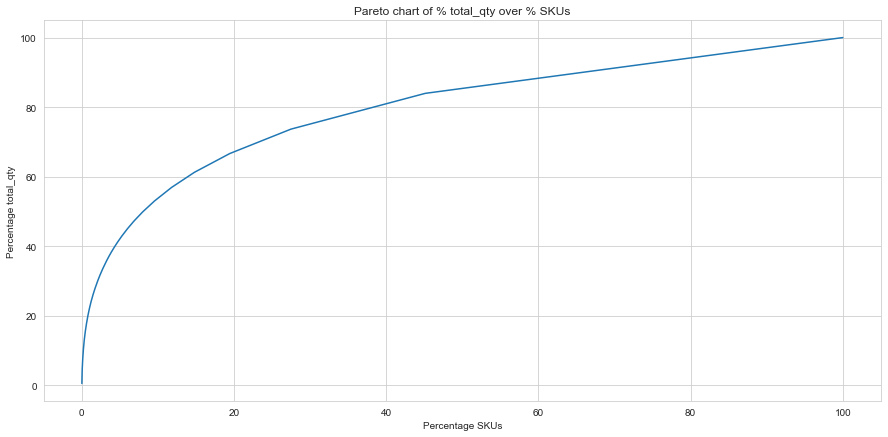

In [210]:
pareto_izer(df_SKUs, 'total_qty');

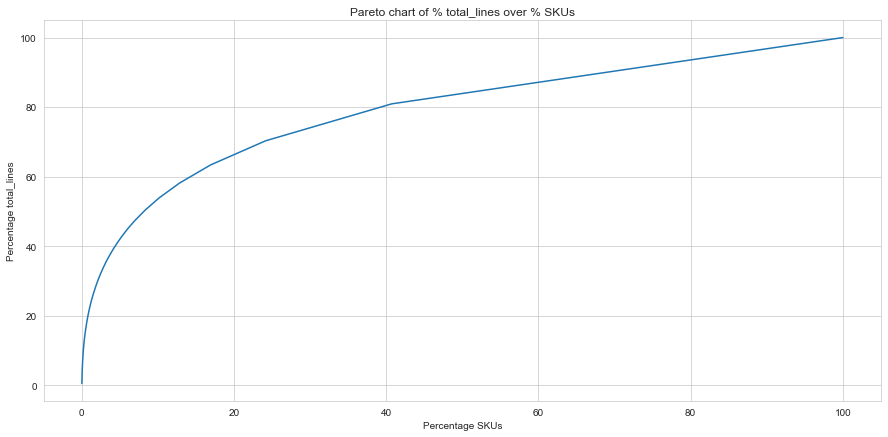

In [211]:
pareto_izer(df_SKUs, 'total_lines');

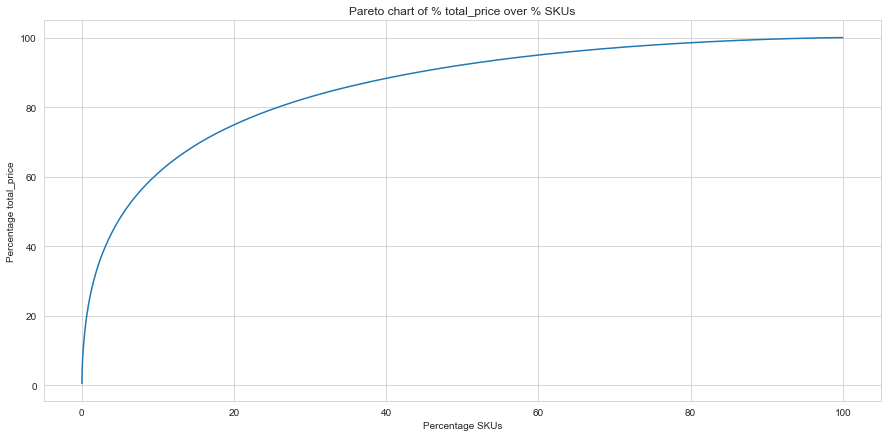

In [212]:
pareto_izer(df_SKUs, 'total_price');

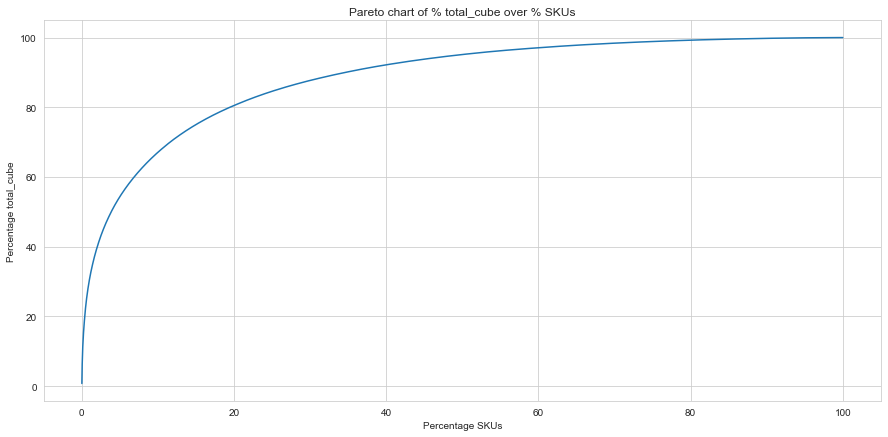

In [213]:
pareto_izer(df_SKUs, 'total_cube');

That looks like a good result. While the pareto charts of the total quantity and lines are following a 70/20 trend, the total price and total cube show a 80/20 curve.

### 3. Adding XYZ profile

The XYZ classification is reflecting how frequently a product was picked and shipped over a time period.
In combination with the ABC classification we archieve one of the most powerful warehouse metrics.

Creating a dataframe which counts the number of active days for each SKU

In [214]:
SKUs_active_days = df_orders_consolidated\
    .groupby(['order_purchase_timestamp', 'product_id'], as_index=False)\
    .agg({'order_id': 'count'})

In [215]:
SKUs_active_days = SKUs_active_days.groupby('product_id', as_index=False)\
    .agg({'order_purchase_timestamp': 'count'})\
    .sort_values(by='order_purchase_timestamp', ascending = False)

In [216]:
SKUs_active_days.rename(columns = {'order_purchase_timestamp': 'active_days'}, inplace = True)

In [217]:
SKUs_active_days.head()

,product_id,active_days
19742,99a4788cb24856965c36a24e339b6058,268
27039,d1c427060a0f73f6b889a5c7c61f2ac4,202
8613,422879e10f46682990de24d770e7f83d,196
5692,2b4609f8948be18874494203496bc318,193
2794,154e7e31ebfa092203795c972e5804a6,192


Adding the XYZ classification column

In [218]:
sample_timespan = df_orders_consolidated['order_purchase_timestamp']\
    .max() - df_orders_consolidated['order_purchase_timestamp'].min()

In [219]:
def xyz_classifier(num):
    t_span = sample_timespan.days
    if num > (t_span * 2 / 3):
        activity_class = 'X'
    elif num > (t_span * 1 / 3):
        activity_class = 'Y'
    else:
        activity_class = 'Z'
        
    return activity_class

In [220]:
SKUs_active_days['XYZ_class'] = SKUs_active_days['active_days'].map(xyz_classifier)

In [221]:
SKUs_active_days

,product_id,active_days,XYZ_class
19742,99a4788cb24856965c36a24e339b6058,268,Y
27039,d1c427060a0f73f6b889a5c7c61f2ac4,202,Z
8613,422879e10f46682990de24d770e7f83d,196,Z
5692,2b4609f8948be18874494203496bc318,193,Z
2794,154e7e31ebfa092203795c972e5804a6,192,Z
...,...,...,...
13675,69ac97e466e0d1329784803bb0d3319e,1,Z
13674,69abb160096c6a83656bff3c715a7497,1,Z
13673,69ab89fdb9df3f93455a0c52d6e4e3f0,1,Z
13672,69a7ee112e7b63892ad5db80e4c3277f,1,Z


Merging SKUs_active_days to df_SKUs

In [222]:
df_SKUs = df_SKUs.merge(SKUs_active_days, on = 'product_id')

Let's plot the XYZ diagram.

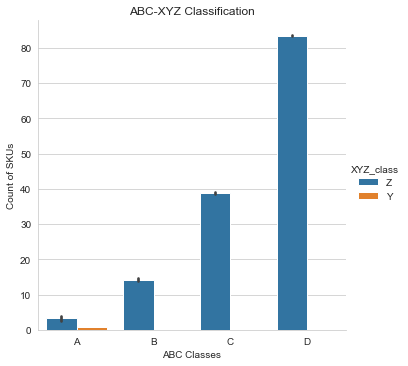

In [223]:
sns.catplot(
    data = df_SKUs,
    x = 'v_class_total_qty',
    y = 'cum_total_qty',
    kind = 'bar',
    aspect = 1,
    hue = 'XYZ_class'
    )
plt.title('ABC-XYZ Classification')
plt.xlabel('ABC Classes')
plt.ylabel('Count of SKUs');

The analysis shows that there is no SKU ranked as X-mover and only some very few as Y. This is an extreme instance and shows that the SKUs are in general very infrequently picked. Even the faster moving SKUs are very infrequently sold which can mean a range of things: 1) That product is highly seasonal, 2) There was a promotion event for these products, 3) These SKUs were a sold out batch without re-ordering

In [224]:
df_SKUs['XYZ_class'].value_counts()

Z    32950
Y        1
Name: XYZ_class, dtype: int64

### 4. Conclusion

** What conclusions can we draw from the order- and SKU-profile? **

** Impacts of Olist business model on inventory and fullfillment process **

- Orders sizes are very small: SIO is 79%, MLO is 93%
- The parato curve is steep, in the range of 75/20 to 80/20, which means a pronounced defferentiation between fast- and slow movers
- SKUs are picked extremely infrequently, with almost 100% Z-movers
- With this XYZ-ABC profile any inventory would not make much sense
- Because of the infrequent picks, batching SIOs would not work

---
## <a class="anchor" id="affinity">IV. Affinity Analysis</a>

Questions to answer:

** Can we predict buying behaviour between articles in one order (association)? **

I will try to answer these questions with an Affinity Analysis (Market Basket Analysis) by using the Apyori library. Basic formulas:

### 1. Basics

How likely SKU B is purchased if SKU A is purchased: $$ Confidence(A\Rightarrow B) = \frac{frq(A, B)}{frq(A)}) $$

How popular is SKU A: $$ Support(A\Rightarrow B) = \frac{frq(A, B)}{N}) $$

In other words: Number of orderlines of the specific products over the total number of order lines of the dataset

SKU B's likelyhood to be bought when SKU A is bought:  $$ Lift(A\Rightarrow B) = \frac{Support}{Supp(A) * Supp(B)}) $$

The orders are so small (93% SLO) that I suspect the assiciation will be very small. As a reminder, the order profile:

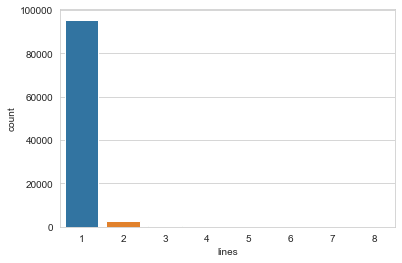

In [225]:
sns.countplot(df_upo_lpo['lines']);

Only for orders with 2 or more lines association can be extracted.

I will extract these MLOs and perform with these the Affinity Analysis.

### 2. Preparing data

Only multi-line orders are interesting, because here we can observe which categories are ordered together.

In [226]:
# List with all multi-line orders
lst_mlo = df_upo_lpo[df_upo_lpo['lines']>1]['order_id'].tolist()

In [227]:
# Extract dataframe with only multi-line orders
df_mlo = df_orders_consolidated[df_orders_consolidated['order_id'].isin(lst_mlo)]

In [228]:
df_mlo.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_time,delivery_time,...,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,order_line_cube_in_ltr,price_round,customer_unique_id,product_category_name_english
0,2e7a8482f6fb09756ca50c10d7bfc047,08c5351a6aca1c1589a38f244edeee9d,shipped,2016-09-04,2016-10-07,2016-10-18,2016-11-09,2016-10-20,21:15:19,13:14:51,...,426.0,2.0,1400.0,32.0,6.0,28.0,5.376,40.0,b7d76e111c89f7ebf14761390f0f7d17,furniture_decor
25,2e7a8482f6fb09756ca50c10d7bfc047,08c5351a6aca1c1589a38f244edeee9d,shipped,2016-09-04,2016-10-07,2016-10-18,2016-11-09,2016-10-20,21:15:19,13:14:51,...,754.0,3.0,1800.0,32.0,6.0,28.0,5.376,30.0,b7d76e111c89f7ebf14761390f0f7d17,furniture_decor
41,fe678293ea3bb6607a15b2e320e91722,70cb12077370218b7b21f70e78d3dfd4,delivered,2017-12-29,2017-12-29,2018-01-02,2018-01-09,2018-01-24,14:05:57,19:22:54,...,823.0,1.0,476.0,17.0,14.0,14.0,3.332,20.0,a3531b78e25e6948ff198a441c30b8eb,sports_leisure
58,dabf2b0e35b423f94618bf965fcb7514,5cdec0bb8cbdf53ffc8fdc212cd247c6,canceled,2016-10-09,2016-10-09,2016-10-13,2016-10-16,2016-11-30,00:56:52,13:36:59,...,605.0,2.0,100.0,20.0,20.0,20.0,8.000,60.0,2f96790fba243100730c8d1185dd2f25,perfumery
76,d25f8fadc7abdec7bc6d97629c97d57a,d29e47a53896a15a89594f91b919553f,delivered,2017-04-17,2017-04-17,2017-04-17,2017-04-27,2017-05-16,06:41:44,09:42:58,...,605.0,2.0,100.0,20.0,20.0,20.0,8.000,60.0,19c77cf8268b9c825eb61e6b5644dc65,perfumery


In [229]:
df_mlo.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'order_time', 'delivery_time', 'date_ordinal', 'shipping_time_delta',
       'shipping_duration', 'estimated_duration', 'product_id', 'qty',
       'seller_id', 'shipping_limit_date', 'price', 'freight_value',
       'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'order_line_cube_in_ltr', 'price_round', 'customer_unique_id',
       'product_category_name_english'],
      dtype='object')

In [230]:
# Generate sparse matrix by using my matric function
mat_mlo_cat = create_category_order_matrix(df_mlo, 'order_id', 'product_category_name_english', 'qty')

In [231]:
mat_mlo_cat.head()

qty                   \
product_category_name_english    agro_industry_and_commerce air_conditioning   
order_id                                                                       
002f98c0f7efd42638ed6100ca699b42                        0.0              0.0   
00337fe25a3780b3424d9ad7c5a4b35e                        0.0              0.0   
005d9a5423d47281ac463a968b3936fb                        0.0              0.0   
00946f674d880be1f188abc10ad7cf46                        0.0              0.0   
0097f0545a302aafa32782f1734ff71c                        0.0              0.0   

                                                                             \
product_category_name_english     art arts_and_craftmanship audio auto baby   
order_id                                                                      
002f98c0f7efd42638ed6100ca699b42  0.0                   0.0   0.0  0.0  0.0   
00337fe25a3780b3424d9ad7c5a4b35e  0.0                   0.0   0.0  0.0  0.0   
005d9a5423d47281ac463a968b3936fb  0.0                   0.0   0.0  0.0  1.0   
00946f674d880be1f188abc10ad7cf46  0.0                   0.0   0.0  0.0  0.0   
0097f0545a302aafa32782f1734ff71c  0.0                   0.0   0.0  0.0  0.0   

                                                                        \
product_category_name_english    bed_bath_table books_general_interest   
order_id                                                                 
002f98c0f7efd42638ed6100ca699b42            0.0                    0.0   
00337fe25a3780b3424d9ad7c5a4b35e            2.0                    0.0   
005d9a5423d47281ac463a968b3936fb            0.0                    0.0   
00946f674d880be1f188abc10ad7cf46            0.0                    0.0   
0097f0545a302aafa32782f1734ff71c            0.0                    0.0   

                                                 ...           \
product_category_name_english    books_imported  ... pet_shop   
order_id                                         ...            
002f98c0f7efd42638ed6100ca699b42            0.0  ...      0.0   
00337fe25a3780b3424d9ad7c5a4b35e            0.0  ...      0.0   
005d9a5423d47281ac463a968b3936fb            0.0  ...      0.0   
00946f674d880be1f188abc10ad7cf46            0.0  ...      2.0   
0097f0545a302aafa32782f1734ff71c            0.0  ...      0.0   

                                                                          \
product_category_name_english    signaling_and_security small_appliances   
order_id                                                                   
002f98c0f7efd42638ed6100ca699b42                    0.0              0.0   
00337fe25a3780b3424d9ad7c5a4b35e                    0.0              0.0   
005d9a5423d47281ac463a968b3936fb                    0.0              0.0   
00946f674d880be1f188abc10ad7cf46                    0.0              0.0   
0097f0545a302aafa32782f1734ff71c                    0.0              0.0   

                                                                        \
product_category_name_english    small_appliances_home_oven_and_coffee   
order_id                                                                 
002f98c0f7efd42638ed6100ca699b42                                   0.0   
00337fe25a3780b3424d9ad7c5a4b35e                                   0.0   
005d9a5423d47281ac463a968b3936fb                                   0.0   
00946f674d880be1f188abc10ad7cf46                                   0.0   
0097f0545a302aafa32782f1734ff71c                                   0.0   

                                                            \
product_category_name_english    sports_leisure stationery   
order_id                                                     
002f98c0f7efd42638ed6100ca699b42            0.0        0.0   
00337fe25a3780b3424d9ad7c5a4b35e            0.0        0.0   
005d9a5423d47281ac463a968b3936fb            0.0        0.0   
00946f674d880be1f188abc10ad7cf46            0.0        0.0   
0097f0545a302aafa32782f1734ff71c

In [232]:
mat_mlo_cat = mat_mlo_cat['qty']

In [233]:
mat_mlo_cat.shape

(3229, 66)

### Support Score
The support score for the prodcuts in this table is simply the mean

In [234]:
mat_mlo_cat.mean().sort_values(ascending=False).head(20)

product_category_name_english
bed_bath_table                     0.477857
furniture_decor                    0.240012
health_beauty                      0.131310
computers_accessories              0.131000
watches_gifts                      0.113657
housewares                         0.112419
sports_leisure                     0.103128
garden_tools                       0.071849
fashion_bags_accessories           0.070920
toys                               0.067203
auto                               0.066584
telephony                          0.061010
perfumery                          0.055125
baby                               0.055125
stationery                         0.052338
pet_shop                           0.040260
cool_stuff                         0.036544
office_furniture                   0.022917
construction_tools_construction    0.022298
home_confort                       0.020749
dtype: float64

### 3. Performing Analysis

In [235]:
# Aryori needs a list with all mlos, where each lmo contains a list with all categories
records = []
for i in range(3229):
    records.append([mat_mlo_cat.values[i, j] for j in range(0, 66)])

In [236]:
# Applying list to apyori algorithm
affinity_model = apriori(mat_mlo_cat, min_support=0.01, use_colnames = True)
affinity_results = list(affinity_model)

How many relations were found?

In [ ]:
print("Relations: {}".format(len(affinity_results)))

In [ ]:
pd.DataFrame(affinity_results)

In [ ]:
mat_mlo_cat

In [ ]:
# Exporting clean order table
#df_orders_consolidated.to_csv("../0 - data\df_orders_consolidated.csv")

### 4. Conclusion

** Can we predict buying behaviour between articles in one order (association)? **

We only found 11 relationships. On top, we only worked with categories. Going one level more detailed (products) would be most likely result in no findings. The small order sizes and the low pick frequency which we could observe in the order profile is also show their impact in this Affinity Analysis.

There is no association between the products. Reasons:
- Very low pick frequency
- Large product range
- Small orders